# Coronavirus tweets NLP - Text Classification

About Dataset
Perform Text Classification on the data. The tweets have been pulled from Twitter and manual tagging has been done then.
The names and usernames have been given codes to avoid any privacy concerns.

Columns:
1) Location
2) Tweet At
3) Original Tweet
4) Label

#pip install text2emotion
#pip install vaderSentiment
Before to start plese install both pip.

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
import re
from wordcloud import WordCloud
import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score
import text2emotion as t2e
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.naive_bayes import MultinomialNB
from datetime import datetime
from datetime import date, timedelta
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [128]:
# Adding my dataset Corona_NLP_test
df = pd.read_csv('Corona_NLP_test.csv')

In [129]:
#description of the data set
df.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
5,6,44958,Los Angeles,03-03-2020,Do you remember the last time you paid $2.99 a...,Neutral
6,7,44959,NaN,03-03-2020,Voting in the age of #coronavirus = hand sanit...,Positive
7,8,44960,"Geneva, Switzerland",03-03-2020,"@DrTedros ""We cant stop #COVID19 without prot...",Neutral
8,9,44961,NaN,04-03-2020,HI TWITTER! I am a pharmacist. I sell hand san...,Extremely Negative
9,10,44962,"Dublin, Ireland",04-03-2020,Anyone been in a supermarket over the last few...,Extremely Positive


So I have 6 clomns in the dataset like UserName, Screen, Location, TweetAT (tweet description on tweet date), OriginalTweet (talking about covid tweets), Sentiment (indicating which sentiment in the tweet like in angry, emotional, positive, negative etc...)

In [130]:
# there is no duplict 
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
3793    False
3794    False
3795    False
3796    False
3797    False
Length: 3798, dtype: bool

In [131]:
#info on data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


In [132]:
# So you can see that there are 5 different Sentiments in the Sentiment column
df['Sentiment'].unique()

array(['Extremely Negative', 'Positive', 'Extremely Positive', 'Negative',
       'Neutral'], dtype=object)

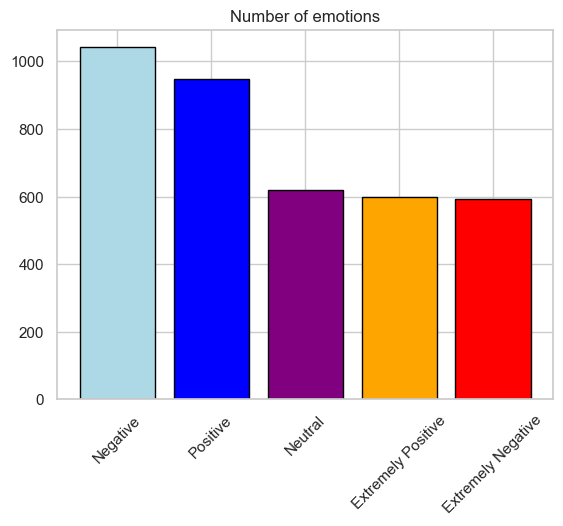

In [133]:
# In this plot you can see Nuber of emotions like for negative there is more then 1000 Tweets etc..... 
sentiments = df.Sentiment.value_counts()
color = ['lightblue', 'blue', 'purple', 'orange', 'red']

plt.bar(sentiments.index, sentiments.values, color= color, edgecolor = 'black')
plt.xticks(rotation = 45)
plt.title('Number of emotions')
plt.show()

In [134]:
# Here is can is exactly number of tweets with emotions
df['Sentiment'].value_counts()

Sentiment
Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: count, dtype: int64

In [135]:
#There are 5 categories in the dataset. I can simplify the opinion analysis to 3 categories: Positive, Negative and Neutral.

def change_labels(label):
    if label == 'Extremely Negative':
        new_label = 'Negative'
    elif label == 'Extremely Positive':
        new_label = 'Positive'
    else:
        new_label = label
    return new_label

df['Sentiment'] = df['Sentiment'].apply(change_labels)
New_df = df['Sentiment']
New_df.unique()

array(['Negative', 'Positive', 'Neutral'], dtype=object)

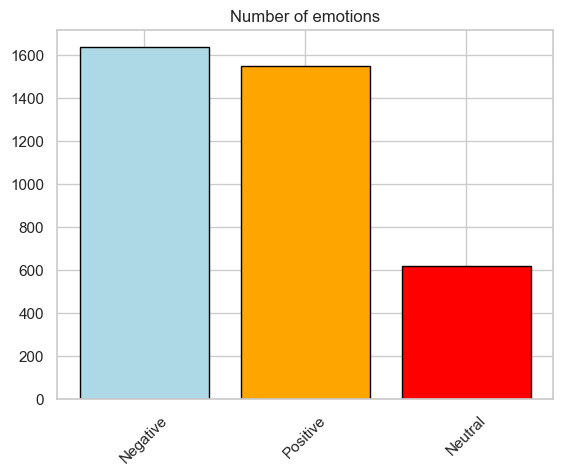

In [136]:
# Here you can see now plot of Sentiment

sentiments = New_df.value_counts()
color = ['lightblue', 'orange', 'red']

plt.bar(sentiments.index, sentiments.values, color = color, edgecolor = 'black')
plt.xticks(rotation = 45)
plt.title('Number of emotions')
plt.show()

In [137]:
# Here is can is exactly number of tweets with emotions
df['Sentiment'].value_counts()

Sentiment
Negative    1633
Positive    1546
Neutral      619
Name: count, dtype: int64

When you combine the tweets, you can see that people's opinions are sharply divided. The number of neutral tweets is very small compared to the other emotions.

For further analysis of opinions, tweets need to be modified by removing, among other things: tags of other users, hashtags used, links and special characters. It is also worth removing counts and so-called stop words. Each word must be modified so that it consists only of lowercase letters.

In [138]:
#Details about column Location
df['Location'].unique()

array(['NYC', 'Seattle, WA', nan, ..., 'Israel ??', 'Farmington, NM',
       'Haverford, PA'], dtype=object)

C:\Users\patel\AppData\Local\Temp\ipykernel_14844\53338554.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(x='Location', y='Sentiment', data=df.head(50), palette='viridis')


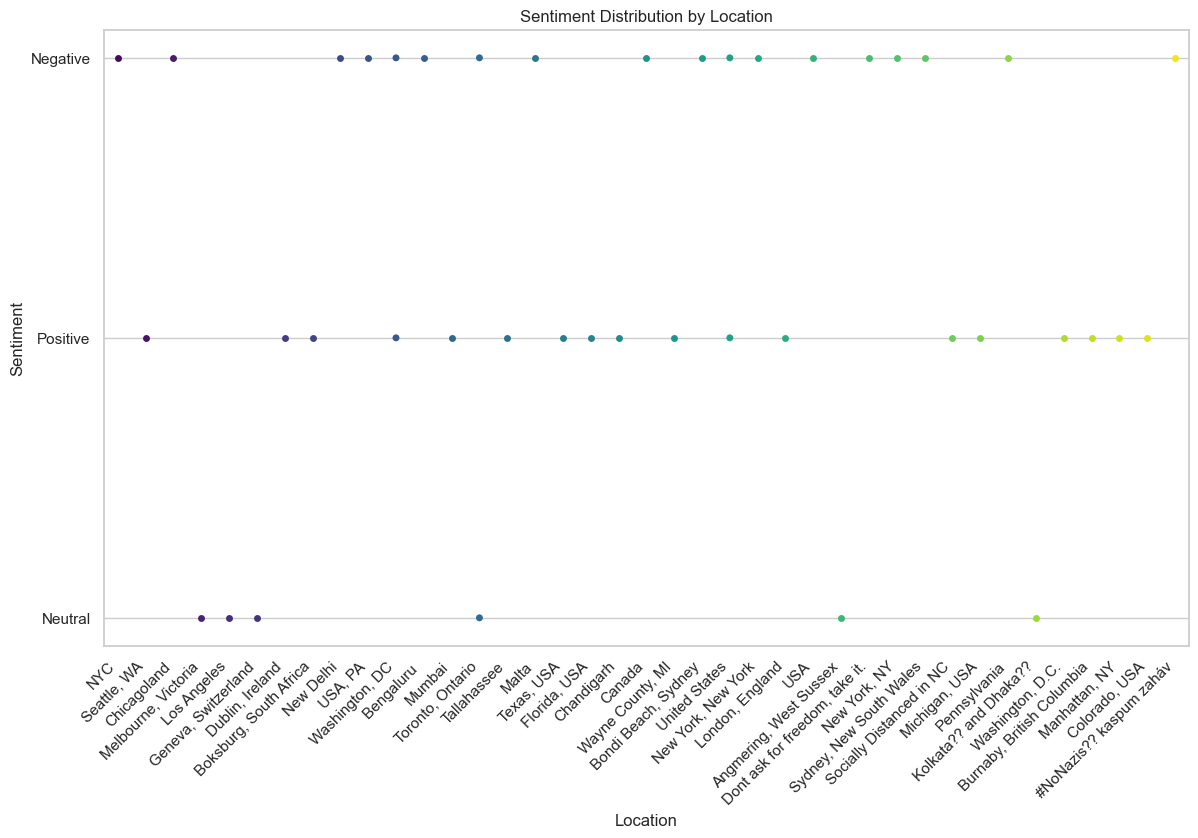

In [139]:
# In this plot, I try to make the connection between lovation and sentiment. like from where we received the most tweets like positive, negative, neutral
# In this plot you can DATA = DF only. I've put only 50 line because it's take so much time to analyse 
plt.figure(figsize=(14, 8))
sns.swarmplot(x='Location', y='Sentiment', data=df.head(50), palette='viridis')
plt.title('Sentiment Distribution by Location')
plt.xlabel('Location')
plt.ylabel('Sentiment')
plt.xticks(rotation=45, ha='right')
plt.show()


In [140]:
#Details about column Tweets
df['OriginalTweet']

0       TRENDING: New Yorkers encounter empty supermar...
1       When I couldn't find hand sanitizer at Fred Me...
2       Find out how you can protect yourself and love...
3       #Panic buying hits #NewYork City as anxious sh...
4       #toiletpaper #dunnypaper #coronavirus #coronav...
                              ...                        
3793    Meanwhile In A Supermarket in Israel -- People...
3794    Did you panic buy a lot of non-perishable item...
3795    Asst Prof of Economics @cconces was on @NBCPhi...
3796    Gov need to do somethings instead of biar je r...
3797    I and @ForestandPaper members are committed to...
Name: OriginalTweet, Length: 3798, dtype: object

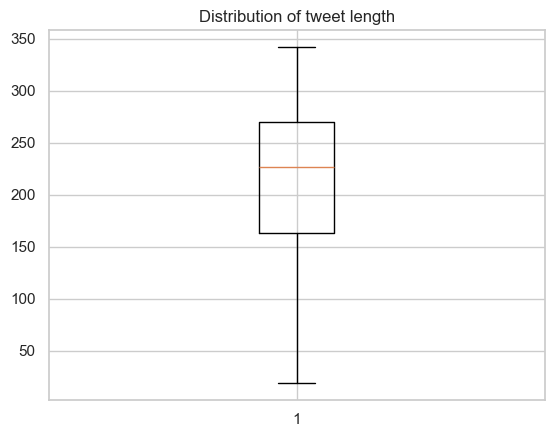

In [141]:
# Tweets anormalement longs/courts
df['tweet_length'] = df['OriginalTweet'].apply(len)
plt.boxplot(df['tweet_length'])
plt.title("Distribution of tweet length")
plt.show()

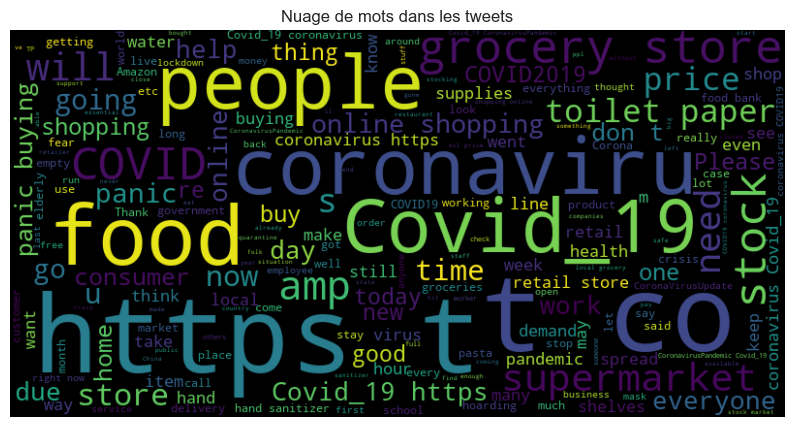

In [142]:
#The plot telling about most words use in covid tweets
#accoding to plot i see that most words use like https, covid_19, pepople, coronaviru, co, etccc....
all_text = ' '.join(df['OriginalTweet'].astype(str))
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(all_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Nuage de mots dans les tweets")
plt.show()